# Bank Classification Project

I will structure my project around [Jeff Leek's data analysis checklist](https://leanpub.com/datastyle).

## The Problem Domain

**Briar's Community Bank** - We are having a campaign. We want people to subscribe to a term deposit. We have been recording our success rate on clients for a while. Can you tell us who we can convert based on their financial data?

We have their age, job, employees, their loans, if they have any credit defaults, when we called them, their education, etc., and we also recorded if our call was successful or not. What can we learn? What would be useful for us?

## Answering the Question

*Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?*

We are trying to classify clients who will subscribe to a term deposit based on several demographic and financial metrics.

*Did you define the metric for success before beginning?*
  
Since we are performing classification, we can use accuracy - the fraction of correctly classified clients - to quantify how well our model is performing. Our head of data has told us that we should achieve at least 90% accuracy.
  
*Did you understand the context for the question and the scientific or business application?*

We are building part of a data analysis pipeline that will be able to classify the client's propensity for term deposits from his/her data on file with the bank. In the future, this pipeline will be connection to another pipeline that automatically generates customized marketing material for clients to be used in digital and print channels.

*Did you record the experimental design?*

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

*Did you consider whether the question could be answered with the available data?*

The data set we currently have is specifically tailored to term deposits. There is additional information about other financial products like a housing loan or personal load, but it would hard to generalize the model to all the other personal financial products offered through a community bank.

## Checking the Data

In [12]:
import pandas as pd

bank_data = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';', na_values=['NA'])
bank_data.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon ...         1    999         0  nonexistent          1.1   
1   may         mon ...         1    999         0  nonexistent          1.1   
2   may         mon ...         1    999         0  nonexistent          1.1   
3   may         mon ...         1    999         0  nonexistent          1.1   
4   may         mon ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

There are several interesting categorical and numerical features. I will need to do more industry research to decide which to filter and which to perform one-hot encoding on. This may lead to a high-dimensional sparse data set. 

In [13]:
bank_data.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
sns.pairplot(bank_data[['age', 'duration', 'campaign', 'previous', 'y']].dropna(), hue='y')

Simple findings
- Number of previous contacts prior to campaign does not seem to affect yes / no
- Age does not seem to play a significant factor
- Larger number of contacts in a campaign is associated with more no
- The data is fairly clean with proper class labels and few missing values (this was used in graduate research)

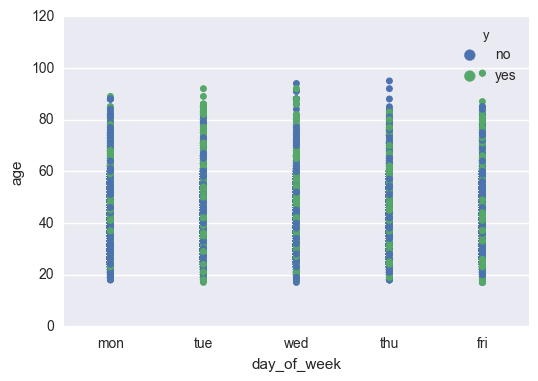

In [16]:
sns.stripplot(x="day_of_week", y="age", hue="y", data=bank_data)

There seems to be a lot of differences between gradations within categorical variables. This may be a good use case for an ensemble of decision trees. Let's test for outliers of 1D Series using subrange ratios and [Dixon's Q-test](http://195.134.76.37/applets/AppletQtest/Appl_Qtest2.html).

In [69]:
def q_test_for_smallest_point(dataset):
    q_ref = 0.29  # the reference Q value for a significance level of 95% and 30 data points
    q_stat = (dataset[1] - dataset[0])/(dataset[-1] - dataset[0])
    
    if q_stat > q_ref:
        print("Since our Q-statistic is {:f} and {:f} > {:f}, we have evidence that our " \
        "minimum point IS an outlier to the data.".format(q_stat, q_stat, q_ref))
    else:
        print("Since our Q-statistic is {:f} and {:f} < {:f}, we have evidence that our " \
        "minimum point is NOT an outlier to the data.".format(q_stat, q_stat, q_ref))


In [70]:
duration = bank_data[100:130]['duration'].values.tolist()
duration.sort()
q_test_for_smallest_point(duration)

Since our Q-statistic is 0.041063 and 0.041063 < 0.290000, we have evidence that our minimum point is NOT an outlier to the data.


In [71]:
campaign = bank_data[100:130]['campaign'].values.tolist()
campaign.sort()
q_test_for_smallest_point(campaign)

Since our Q-statistic is 0.000000 and 0.000000 < 0.290000, we have evidence that our minimum point is NOT an outlier to the data.


In [ ]:
pdays = bank_data[100:130]['pdays'].values.tolist()
pdays.sort()
q_test_for_smallest_point(pdays)

[Additional Outlier Tests](http://colingorrie.github.io/outlier-detection.html)

## Tidying the Data

- Each variable is associated with one column
- Each observation is associated with one row

In [7]:
bank_data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

As noted before, the numerical is in the right int / float format, however, there is potentially a wealth of information hidden in the categorical data and text responses.

### Attribute Information for Reference

#### Bank client data

1. age (numeric)

2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5. default: has credit in default? (categorical: 'no','yes','unknown')

6. housing: has housing loan? (categorical: 'no','yes','unknown')

7. loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the last contact of the current campaign

8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). 

*Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*

#### Other attributes

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Social and economic context attributes

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

21. y - has the client subscribed a term deposit? (binary: 'yes','no')

The data is well cleaned so not much is needed in this step.

## Exploratory Analysis

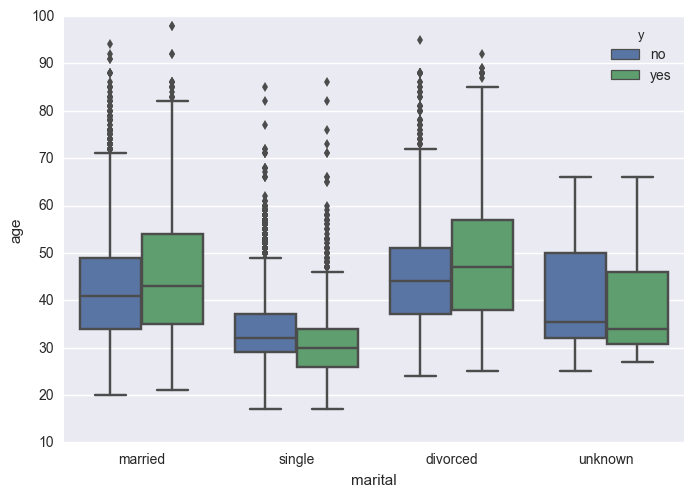

In [11]:
sns.boxplot(x="marital", y="age", hue="y", data=bank_data)

In [16]:
sns.violinplot(x="previous", y="education", hue="y", data=bank_data, split=True)

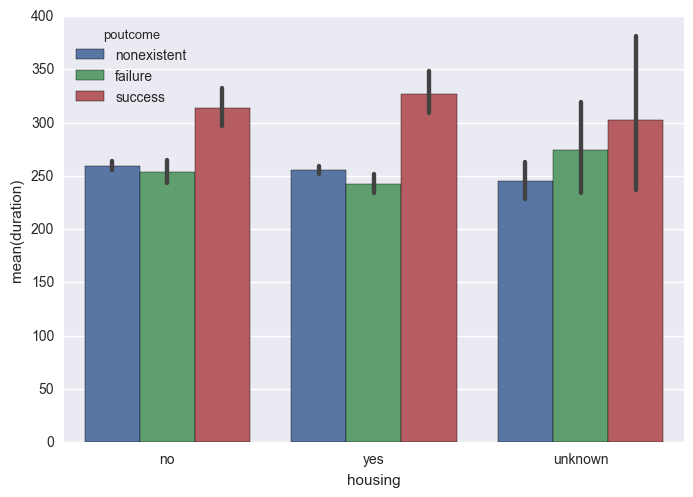

In [18]:
sns.barplot(x="housing", y="duration", hue="poutcome", data=bank_data)

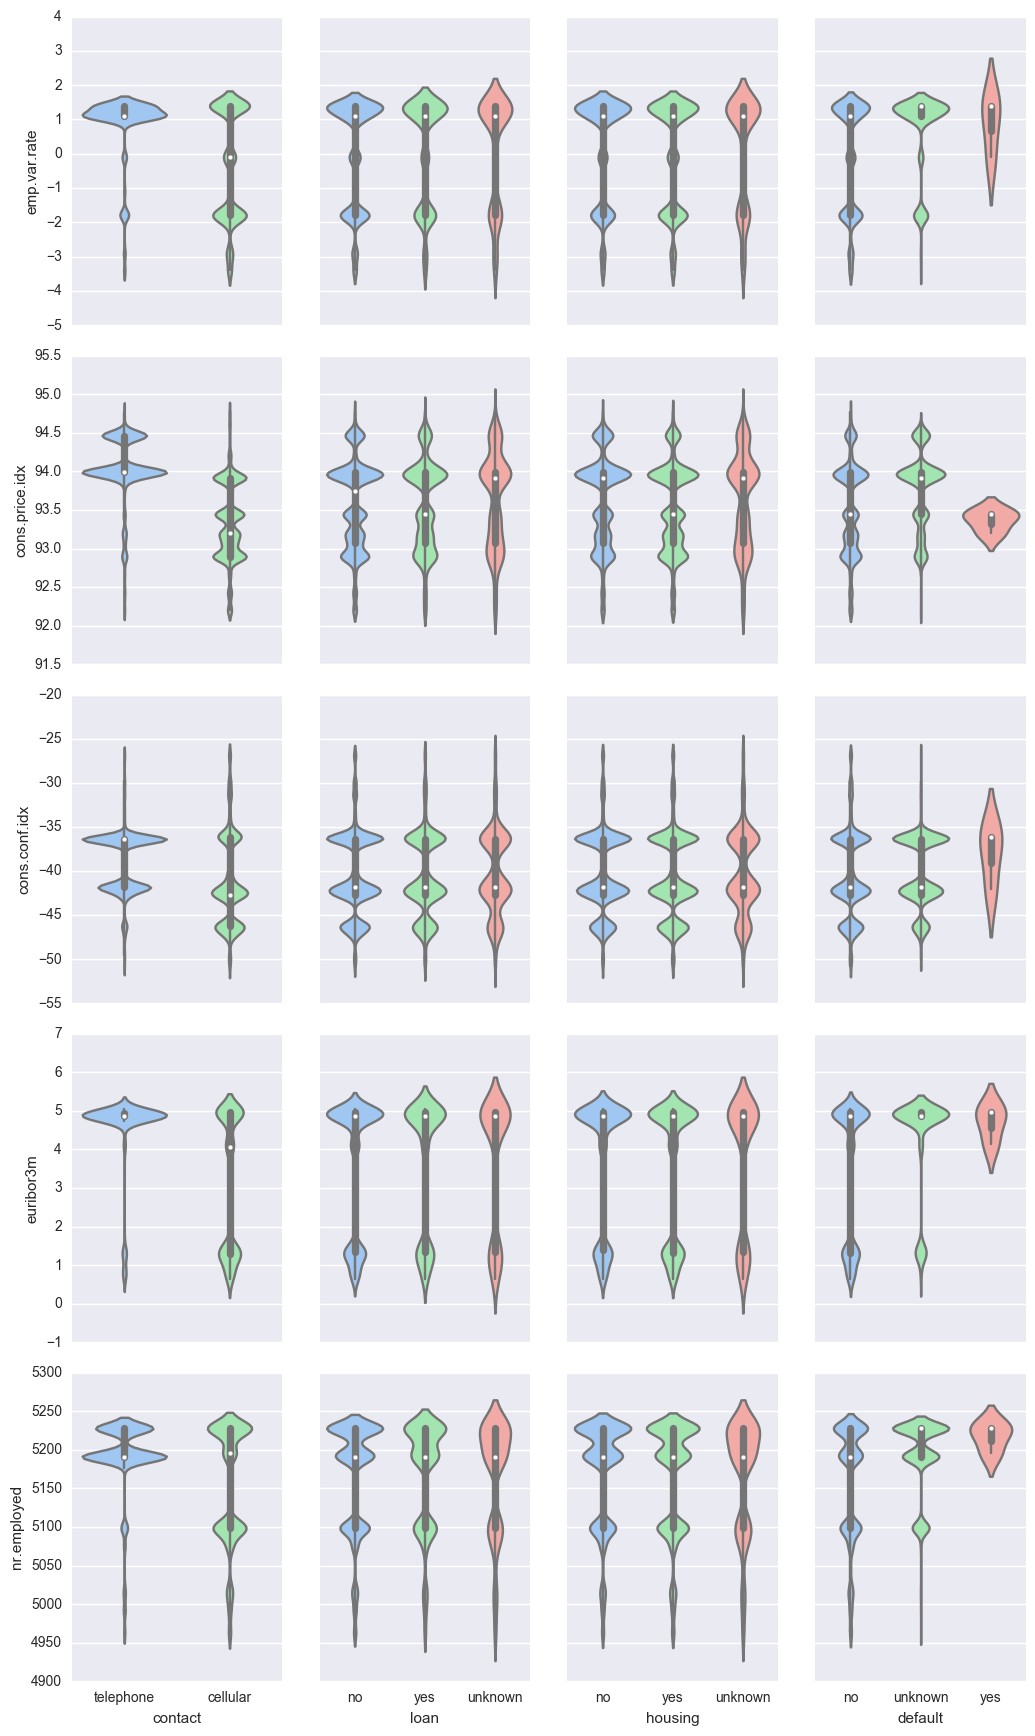

In [20]:
g = sns.PairGrid(bank_data,
                 x_vars=["contact", "loan", "housing", "default"],
                 y_vars=["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
                 aspect=.75, size=3.5)
g.map(sns.violinplot, palette="pastel");

Enough exploration, let's dig into the modeling phase.

## Prediction

- Accuracy error measure
- Train/test split with cross-validation
- Feature engineering

In [65]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(bank_data, train_size=0.75, random_state=1)

#### Steps to Feature Engineering
- Change yes/no to 1/0
- Drop Unknowns
- Delete features that cannot be used for new clients
- Add dummies for categorical variables
- Format and organize DataFrame

In [28]:
import numpy as np

train_df = train_df.replace(['yes', 'no'], [1, 0])

cols = train_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
train_df = train_df[cols]

train_df.replace(['unknown'], [np.nan], inplace=True)
train_df = train_df.dropna()

for i in ['duration', 'campaign', 'pdays', 'previous', 'poutcome']:
    del train_df[i]

train_df = pd.get_dummies(train_df, columns=['month', 'day_of_week', 'job', 'marital', 'education', 'contact'])

In [29]:
train_df.head()

y  age  default  housing  loan  emp.var.rate  cons.price.idx  \
24840  0   43      0.0      1.0   0.0          -0.1          93.200   
33359  1   48      0.0      1.0   0.0          -1.8          92.893   
1903   0   30      0.0      0.0   1.0           1.1          93.994   
25740  0   35      0.0      1.0   0.0          -0.1          93.200   
19597  0   39      0.0      1.0   0.0           1.4          93.444   

       cons.conf.idx  euribor3m  nr.employed        ...          \
24840          -42.0      4.153       5195.8        ...           
33359          -46.2      1.291       5099.1        ...           
1903           -36.4      4.855       5191.0        ...           
25740          -42.0      4.120       5195.8        ...           
19597          -36.1      4.968       5228.1        ...           

       marital_single  education_basic.4y  education_basic.6y  \
24840             0.0                 0.0                 0.0   
33359             0.0                 0.0                 0.0   
1903              0.0                 0.0                 0.0   
25740             0.0                 0.0                 0.0   
19597             0.0                 0.0                 0.0   

       education_basic.9y  education_high.school  education_illiterate  \
24840                 0.0                    0.0                   0.0   
33359                 1.0                    0.0                   0.0   
1903                  0.0                    0.0                   0.0   
25740                 1.0                    0.0                   0.0   
19597                 0.0                    0.0                   0.0   

       education_professional.course  education_university.degree  \
24840                            1.0                          0.0   
33359                            0.0                          0.0   
1903                             1.0                          0.0   
25740                            0.0                          0.0   
19597                            0.0                          1.0   

       contact_cellular  contact_telephone  
24840               0.0                1.0  
33359               1.0                0.0  
1903                0.0                1.0  
25740               1.0                0.0  
19597               1.0                0.0  

[5 rows x 48 columns]

In [ ]:
# Remove "." from titles

train_df.columns = ['y', 'age', 'default', 'housing', 'loan', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'job_admin_', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_basic_4y', 'education_basic_6y',
       'education_basic_9y', 'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'contact_cellular', 'contact_telephone']

In [32]:
train_X = train_df.drop('y', axis=1)
train_y = train_df['y']

In [33]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(train_X, train_y)
decision_tree_classifier.score(train_X, train_y)

0.98422202797202796

Great, I got 98.4% accuracy on my training set. Let's use cross-validation to split the original training data set into k subsets, use one of the subsets as the testing set and the rest of the subsets are used as the new training set.

/Users/osx10/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


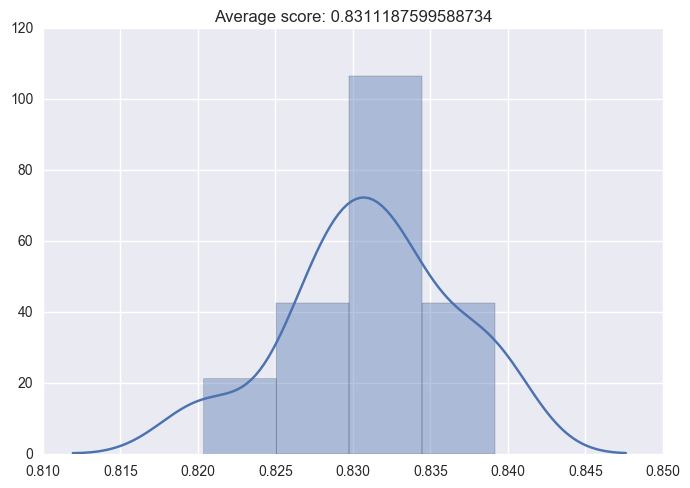

In [36]:
from sklearn.cross_validation import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, train_X, train_y, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

This is a fairly consistent rating of our classifier's general classification accuracy. Let's try **parameter tuning**.

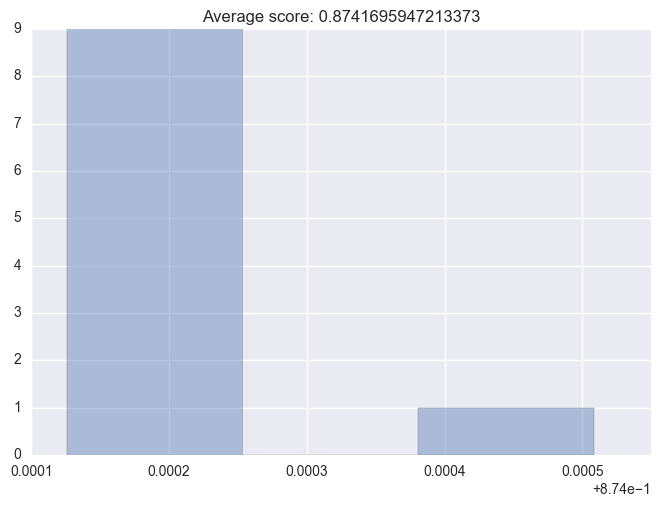

In [37]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, train_X, train_y, cv=10)
sns.distplot(cv_scores, kde=False)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

The classification accuracy increases if we severely limit the depth of our decision tree classifier.

The most common method for model parameter tuning is **grid search**. The idea behind Grid Search is simple: explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier. We'll stick to only two parameters for now, but it's possible to simultaneously explore dozens of parameters if we want.

In [39]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(train_y, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_X, train_y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8760489510489511
Best parameters: {'max_depth': 5, 'max_features': 4}


Now let's visualize the grid search to see how the parameters interact.

In [46]:
grid_visualization = []

for score in grid_search.cv_results_['mean_test_score']:
    grid_visualization.append(score)
    
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (5, 4)
sns.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'][::-1])
plt.xlabel('max_features')
plt.ylabel('max_depth')

Now we have a better sense of the parameter space: the parameters do not see to make quite a difference.

Let's go ahead and use a broad grid search to find the best settings for a handful of parameters.


In [48]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(train_y, n_folds=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_X, train_y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8763111888111889
Best parameters: {'splitter': 'best', 'max_features': 4, 'max_depth': 5, 'criterion': 'gini'}


Now we can take the best classifier from the Grid Search and use that:

In [49]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [50]:
import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('bank_dtc.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

**Random Forest classifiers** usually work better than individual decision trees. A common problem that decision trees face is that they're prone to overfitting: They complexity to the point that they classify the training set near-perfectly, but fail to generalize to data they have not seen before.

Random Forest classifiers work around that limitation by creating a whole bunch of decision trees (hence "forest") — each trained on random subsets of training samples (drawn with replacement) and features (drawn without replacement) — and have the decision trees work together to make a more accurate classification.

Let's see if a Random Forest classifier works better here.

The great part about scikit-learn is that the training, testing, parameter tuning, etc. process is the same for all models, so we only need to plug in the new classifier.

In [52]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [5, 10, 25, 50],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4],
                  'warm_start': [True, False]}

cross_validation = StratifiedKFold(train_y, n_folds=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_X, train_y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.8690559440559441
Best parameters: {'n_estimators': 50, 'warm_start': True, 'max_features': 3, 'criterion': 'entropy'}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)

Now we can compare their performance:

In [54]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, train_X, train_y, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, train_X, train_y, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sns.boxplot(x='classifier', y='accuracy', data=both_df)
sns.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='white')

The decision tree classifier had a higher accuracy. Let's put the out-of-sample test set through our pipeline and see the results.

In [66]:
test_df = test_df.replace(['yes', 'no'], [1, 0])

cols = test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
test_df = test_df[cols]

test_df.replace(['unknown'], [np.nan], inplace=True)
test_df = test_df.dropna()

for i in ['duration', 'campaign', 'pdays', 'previous', 'poutcome']:
    del test_df[i]

test_df = pd.get_dummies(test_df, columns=['month', 'day_of_week', 'job', 'marital', 'education', 'contact'])

test_df.columns = ['y', 'age', 'default', 'housing', 'loan', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'job_admin_', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_basic_4y', 'education_basic_6y',
       'education_basic_9y', 'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'contact_cellular', 'contact_telephone']

test_X = test_df.drop('y', axis=1)
test_y = test_df['y']

In [83]:
for _, prediction, actual in zip(test_X.values[:10], decision_tree_classifier.predict(test_X.values[:10]), test_y.values[:10]):
    print('{}\t(Actual: {})'.format(prediction, actual))

0	(Actual: 1)
0	(Actual: 0)
0	(Actual: 0)
0	(Actual: 0)
0	(Actual: 0)
0	(Actual: 0)
0	(Actual: 0)
0	(Actual: 0)
0	(Actual: 0)
0	(Actual: 0)


In [86]:
print('Score: ', decision_tree_classifier.score(test_X.values, test_y.values))

Score:  0.871713985279


Will definitely need to some more feature engineering in order to get >90% Accuracy. The pipeline is flexible enough to handle new data from additional campaigns when that data set is ready. The out-of-sample testing data accuracy score was extremely close to the cross-validation accuracy scores. Our model does not overfit and generalizes well for unseen data.

## Written Analysis

In [ ]:
## See Repository README

## Grade - C

## Additional Analysis

- Feature Engineering
- Dimensionality Reduction
- Gradient Boosting
- ROC / AUC 
- Additional Classifiers
- Testing Scores with Bootstrapping and Permutation Tests